In [1]:
# ================================================================
# FEATURE ENGINEERING PIPELINE - NEWS MOOD PREDICTION (FAST VERSION)
# ================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
import nltk
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.facecolor"] = "white"

print("="*70)
print("FEATURE ENGINEERING PIPELINE (FAST, STABLE VERSION)")
print("="*70)

# ---------------------------------------------------------
# SETUP
# ---------------------------------------------------------
print("\n🔧 Downloading required NLTK lexicons...")

# Ensure packages are downloaded quietly
for pkg in ["vader_lexicon", "opinion_lexicon"]:
    try:
        nltk.data.find(f'corpora/{pkg}') # Check if exists
    except LookupError:
        nltk.download(pkg, quiet=True)

# ---------------------------------------------------------
# LOAD CLEANED DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv("../data/cleaned_news_data.csv")
    df["cleaned_text"] = df["cleaned_text"].fillna("")
    # Lowercase tokens for better matching in lexicons
    df["tokens"] = df["cleaned_text"].apply(lambda x: str(x).lower().split())
    print(f"✅ Loaded {len(df)} cleaned articles.\n")
except FileNotFoundError:
    print("❌ Error: cleaned_news_data.csv not found.")
    exit()

# =========================================================
# 1️⃣ BASIC TEXT FEATURES
# =========================================================
print("="*60)
print("1️⃣ BASIC TEXT FEATURES")
print("="*60)

df["char_length"] = df["cleaned_text"].str.len()
df["word_count"] = df["tokens"].str.len()
df["avg_word_length"] = df["tokens"].apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
df["sentence_count"] = df["cleaned_text"].str.count(r"[.!?]") + 1
df["avg_sentence_length"] = df["word_count"] / df["sentence_count"]

df["punctuation_count"] = df["cleaned_text"].apply(
    lambda x: sum(1 for c in str(x) if c in "!?.,;:")
)
df["punctuation_ratio"] = df["punctuation_count"] / (df["char_length"] + 1)

df["unique_word_count"] = df["tokens"].apply(lambda x: len(set(x)))
df["unique_word_ratio"] = df["unique_word_count"] / (df["word_count"] + 1)

df["digit_count"] = df["cleaned_text"].str.count(r"\d")

print("✅ Basic features extracted.")


# =========================================================
# 2️⃣ TEMPORAL FEATURES
# =========================================================
print("\n" + "="*60)
print("2️⃣ TEMPORAL FEATURES")
print("="*60)

if "published_at" in df.columns:
    df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
    df["year"] = df["published_at"].dt.year
    df["month"] = df["published_at"].dt.month
    df["weekday"] = df["published_at"].dt.weekday
    df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)
    print("✅ Temporal features created.")
else:
    print("⚠️ No published_at column found – skipping.")


# =========================================================
# 3️⃣ SENTIMENT FEATURES (VADER + Lexicon)
# =========================================================
print("\n" + "="*60)
print("3️⃣ SENTIMENT FEATURES")
print("="*60)

# --- Opinion Lexicon ---
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

def lexicon_counts(tokens):
    # Set intersection is very fast
    token_set = set(tokens)
    pos = len(token_set.intersection(pos_words))
    neg = len(token_set.intersection(neg_words))
    return pd.Series([pos, neg])

df[["pos_word_count", "neg_word_count"]] = df["tokens"].apply(lexicon_counts)
df["sentiment_ratio"] = (df["pos_word_count"] - df["neg_word_count"]) / (
    df["pos_word_count"] + df["neg_word_count"] + 1
)

# --- VADER ---
vader = SentimentIntensityAnalyzer()
# Compute all VADER scores at once for efficiency
def get_vader(text):
    scores = vader.polarity_scores(str(text))
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

df[["vader_neg", "vader_neu", "vader_pos", "vader_compound"]] = df["cleaned_text"].apply(get_vader)

# Aggregate sentiment
df["aggregate_sentiment"] = (
    0.6 * df["vader_compound"] + 0.4 * df["sentiment_ratio"]
)

# Categorize
df["sentiment_category"] = pd.cut(
    df["aggregate_sentiment"],
    bins=[-float('inf'), -0.05, 0.05, float('inf')],
    labels=["Negative", "Neutral", "Positive"]
)

print("✅ Sentiment features extracted.")


# =========================================================
# 4️⃣ EMOTION FEATURES (RULE-BASED)
# =========================================================
print("\n" + "="*60)
print("4️⃣ EMOTION FEATURES (Rule-Based)")
print("="*60)

# Optimized dictionary (using sets for O(1) lookup)
emotion_keywords = {
    "joy": {"happy", "joy", "celebrate", "success", "win", "won", "victory", "smile", "laugh"},
    "sadness": {"sad", "loss", "death", "hurt", "grief", "cry", "mourn", "tragedy", "fail"},
    "anger": {"angry", "rage", "furious", "attack", "protest", "fight", "conflict", "hate"},
    "fear": {"fear", "threat", "terror", "panic", "violence", "danger", "scare", "afraid"},
    "trust": {"trust", "secure", "support", "stable", "believe", "friend", "agree"},
    "disgust": {"disgust", "hate", "shame", "sick", "nasty", "gross"},
    "surprise": {"surprise", "shock", "unexpected", "sudden", "stun", "amazed"},
    "anticipation": {"expect", "plan", "prepare", "hope", "wait", "soon"},
}

def emotion_counts_fast(tokens):
    token_set = set(tokens)
    return pd.Series({
        f"emo_{emo}": len(token_set.intersection(words)) 
        for emo, words in emotion_keywords.items()
    })

emotion_df = df["tokens"].apply(emotion_counts_fast)
df = pd.concat([df, emotion_df], axis=1)

# Sum emotions
df["emotion_total"] = emotion_df.sum(axis=1)

# Dominant emotion (safely)
df["dominant_emotion"] = emotion_df.idxmax(axis=1).str.replace('emo_', '').str.title()

print("✅ Emotion features extracted.")


# =========================================================
# 5️⃣ READABILITY FEATURES
# =========================================================
print("\n" + "="*60)
print("5️⃣ READABILITY FEATURES")
print("="*60)

df["long_word_count"] = df["tokens"].apply(
    lambda x: sum(1 for w in x if len(w) > 6)
)
df["long_word_ratio"] = df["long_word_count"] / (df["word_count"] + 1)
df["lexical_diversity"] = df["unique_word_count"] / (df["word_count"] + 1)

print("✅ Readability features extracted.")


# =========================================================
# 6️⃣ TF-IDF + SVD (Dimensionality Reduction)
# =========================================================
print("\n" + "="*60)
print("6️⃣ TF-IDF + SVD")
print("="*60)

tfidf = TfidfVectorizer(max_features=2000, stop_words="english")
X_tfidf = tfidf.fit_transform(df["cleaned_text"])

svd = TruncatedSVD(n_components=5, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

df["svd_1"] = X_svd[:, 0]
df["svd_2"] = X_svd[:, 1]
df["svd_3"] = X_svd[:, 2]
df["svd_4"] = X_svd[:, 3]
df["svd_5"] = X_svd[:, 4]

print(f"✅ SVD complete. Variance explained: {svd.explained_variance_ratio_.sum():.2%}")


# =========================================================
# SAVE ENGINEERED FEATURES
# =========================================================
print("\n" + "="*70)
print("💾 Saving Engineered Dataset")
print("="*70)

# Drop intermediate/large columns
if "tokens" in df.columns:
    df.drop(columns=["tokens"], inplace=True)

output_path = "../data/engineered_features.csv"
df.to_csv(output_path, index=False)

print(f"✅ Saved to {output_path}")
print(f"📊 Final shape: {df.shape}")
print("="*70)
print("🎉 Feature Engineering Complete!")

FEATURE ENGINEERING PIPELINE (FAST, STABLE VERSION)

🔧 Downloading required NLTK lexicons...


✅ Loaded 834 cleaned articles.

1️⃣ BASIC TEXT FEATURES
✅ Basic features extracted.

2️⃣ TEMPORAL FEATURES
✅ Temporal features created.

3️⃣ SENTIMENT FEATURES


✅ Sentiment features extracted.

4️⃣ EMOTION FEATURES (Rule-Based)


✅ Emotion features extracted.

5️⃣ READABILITY FEATURES
✅ Readability features extracted.

6️⃣ TF-IDF + SVD
✅ SVD complete. Variance explained: 4.26%

💾 Saving Engineered Dataset


✅ Saved to ../data/engineered_features.csv
📊 Final shape: (834, 53)
🎉 Feature Engineering Complete!



📊 ADVANCED FEATURE VISUALIZATIONS


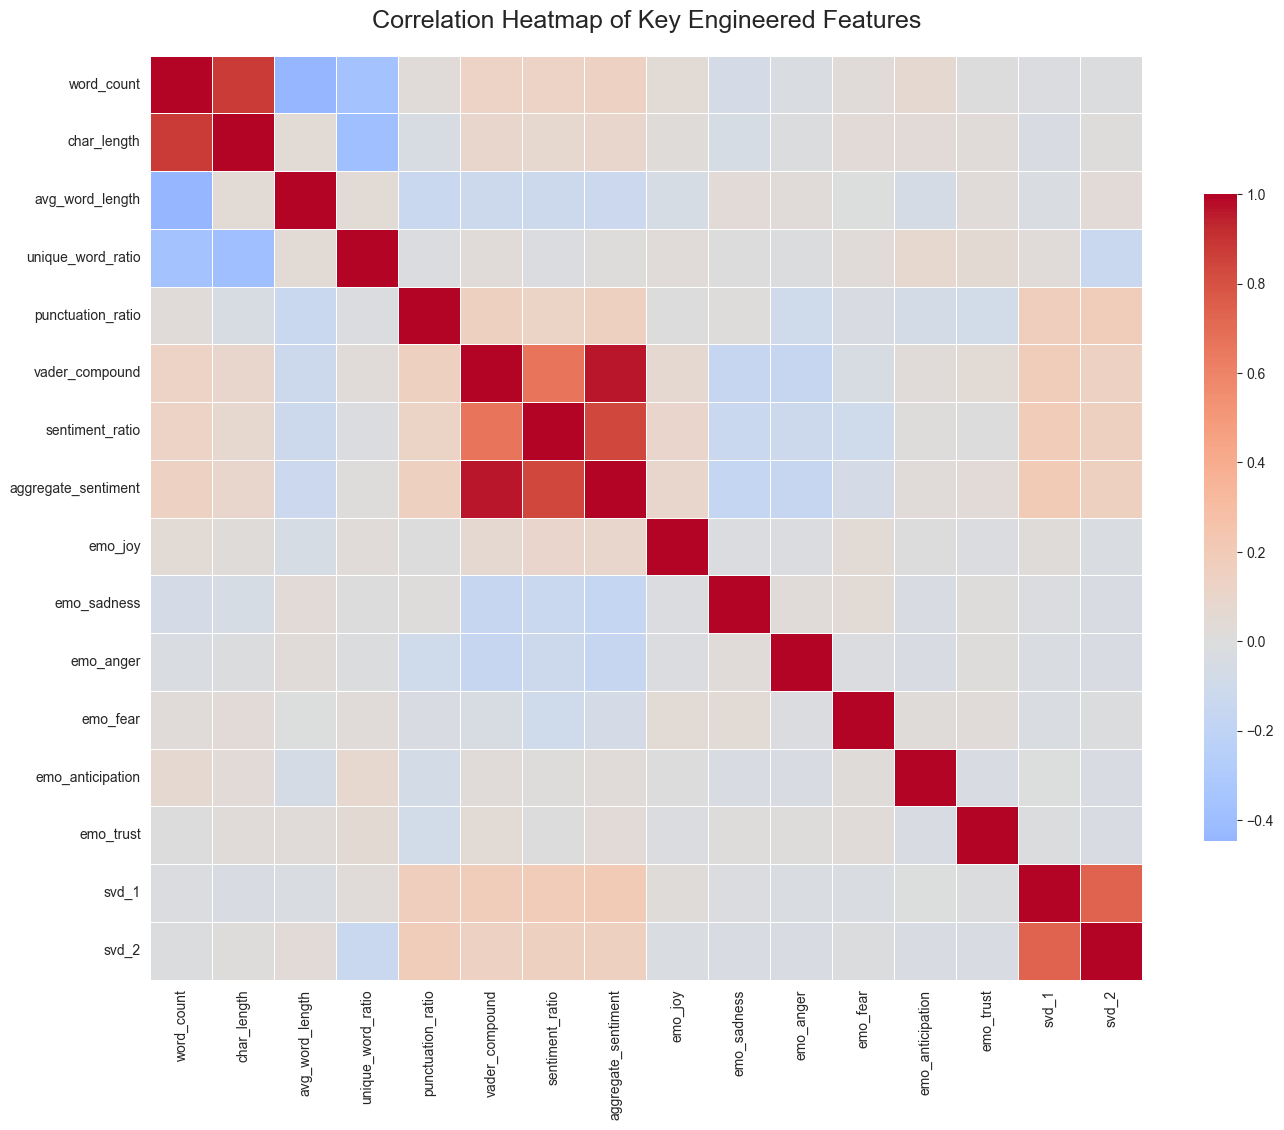

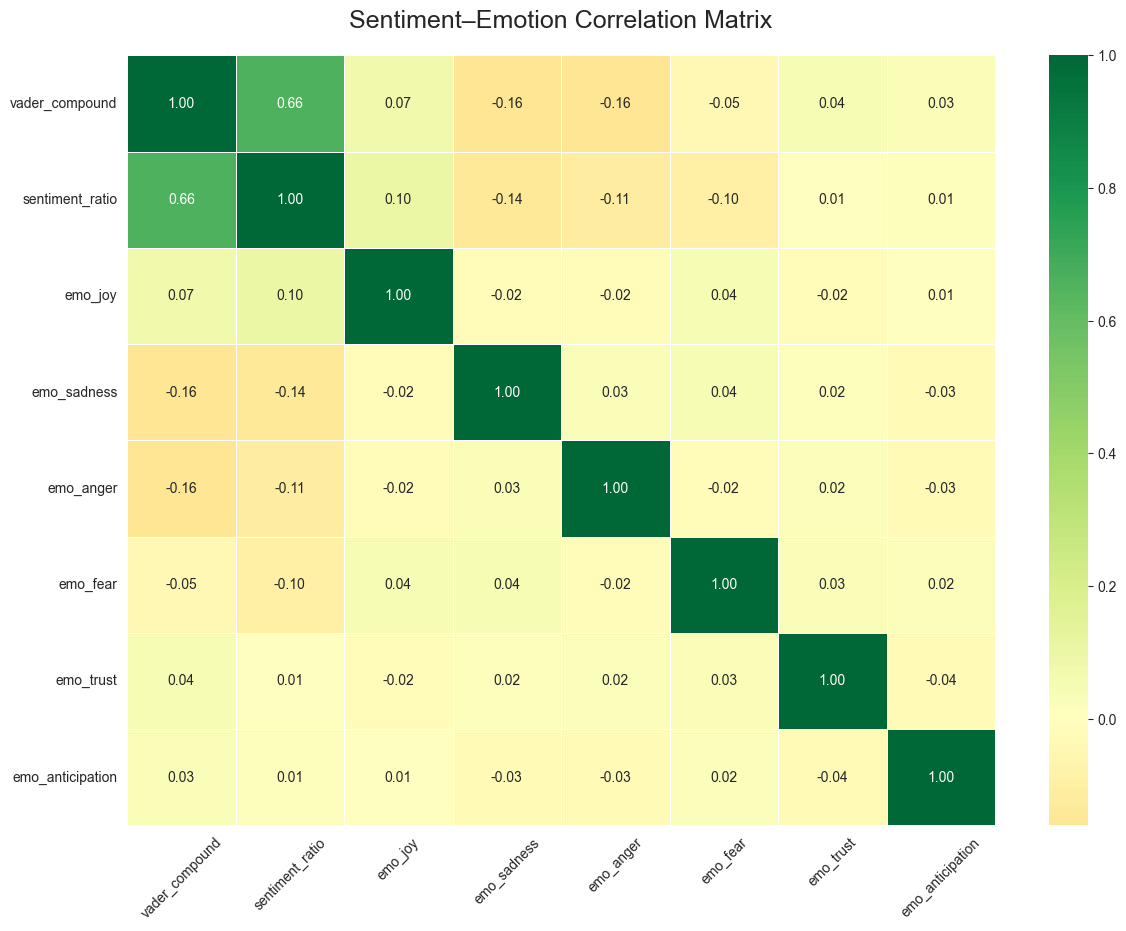

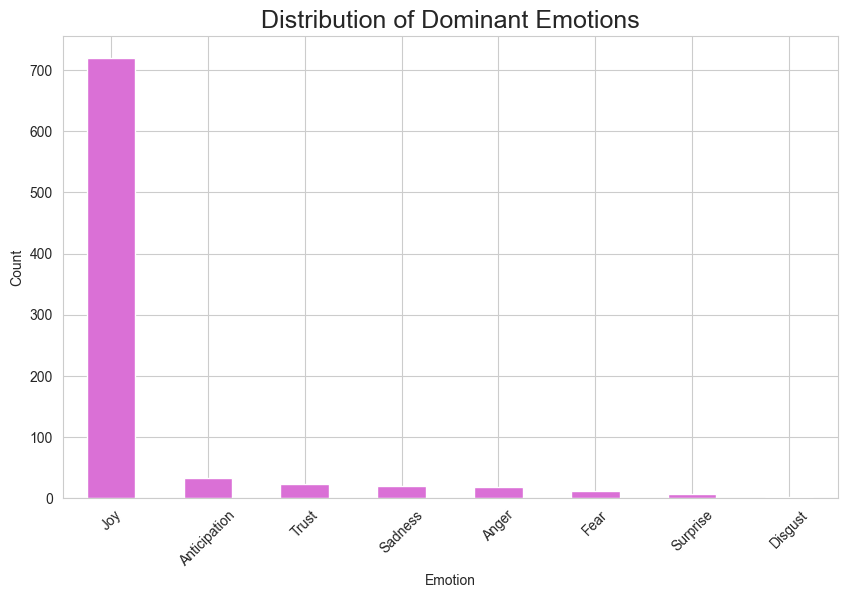

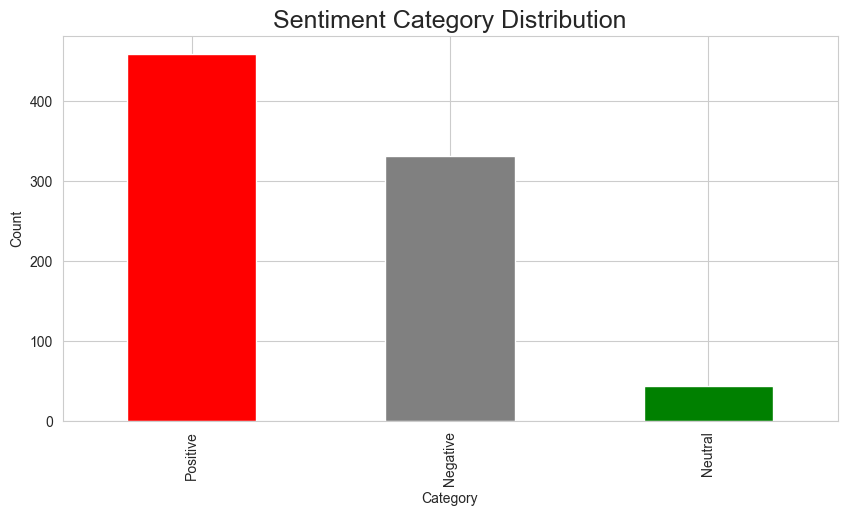


📌 Feature Importance Based on Correlation with Aggregate Sentiment


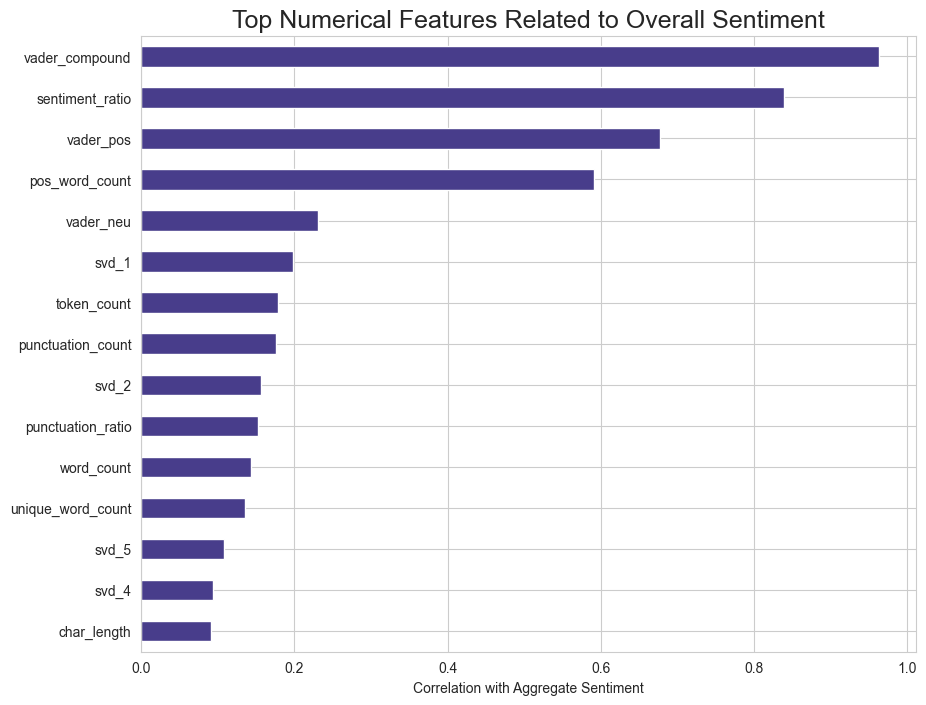

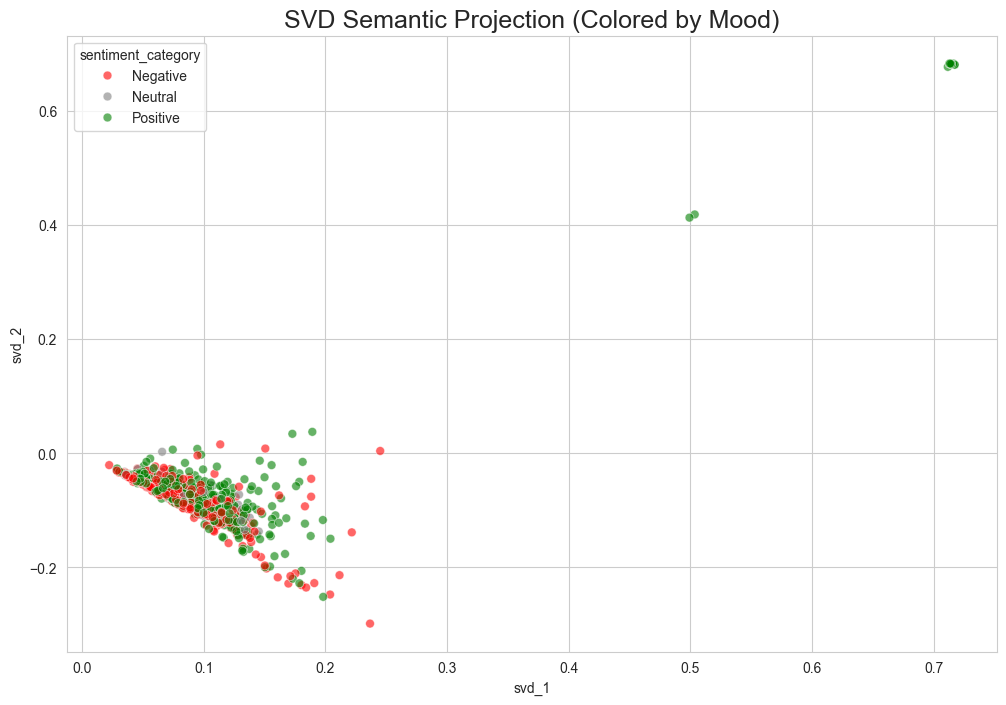

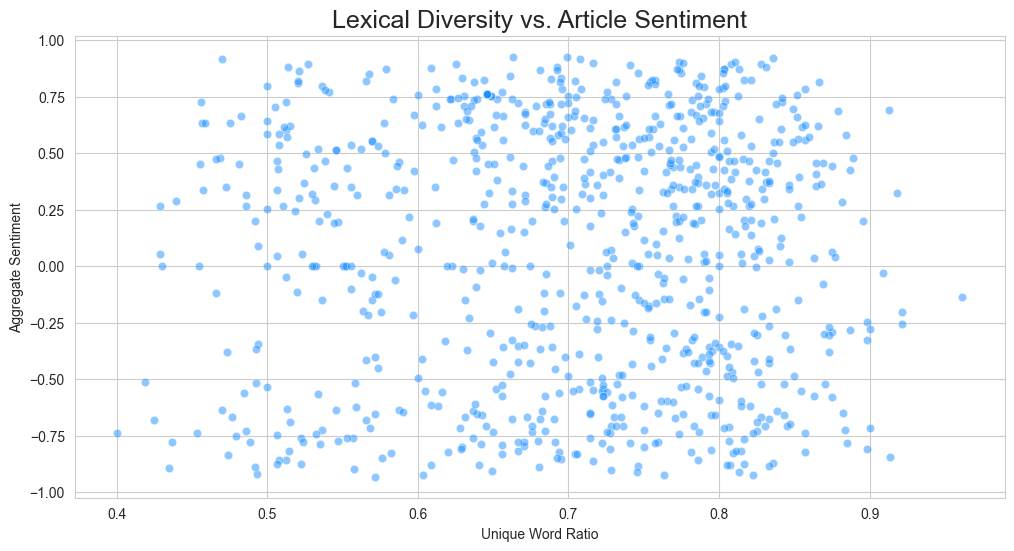

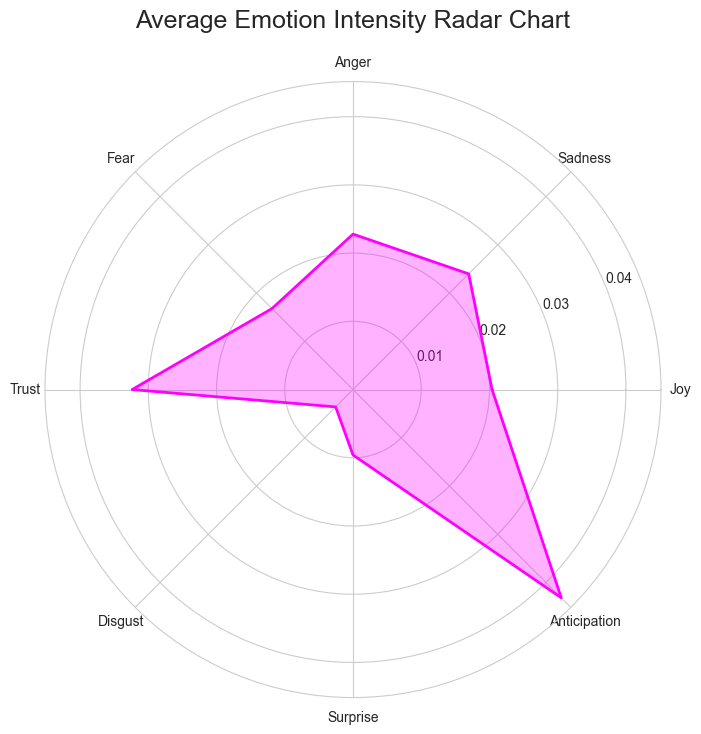

In [2]:
# ============================================================
# 📊 ADVANCED VISUALIZATIONS FOR FEATURE ANALYSIS
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

print("\n" + "="*70)
print("📊 ADVANCED FEATURE VISUALIZATIONS")
print("="*70)


# ------------------------------------------------------------
# 1️⃣ Correlation Heatmap of Key Features
# ------------------------------------------------------------
key_corr_features = [
    # text structure
    "word_count", "char_length", "avg_word_length",
    "unique_word_ratio", "punctuation_ratio",

    # sentiment
    "vader_compound", "sentiment_ratio", "aggregate_sentiment",

    # emotions
    "emo_joy", "emo_sadness", "emo_anger",
    "emo_fear", "emo_anticipation", "emo_trust",

    # dimensional components
    "svd_1", "svd_2"
]

existing = [c for c in key_corr_features if c in df.columns]
corr = df[existing].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.7})
plt.title("Correlation Heatmap of Key Engineered Features", fontsize=18, pad=20)
plt.show()


# ------------------------------------------------------------
# 2️⃣ Sentiment vs Emotions Relationship Heatmap
# ------------------------------------------------------------
sent_emo_cols = [
    "vader_compound", "sentiment_ratio",
    "emo_joy", "emo_sadness", "emo_anger",
    "emo_fear", "emo_trust", "emo_anticipation"
]

sent_emo_cols = [c for c in sent_emo_cols if c in df]

plt.figure(figsize=(14, 10))
sns.heatmap(df[sent_emo_cols].corr(), annot=True, fmt=".2f",
            cmap="RdYlGn", linewidths=0.6, center=0)
plt.title("Sentiment–Emotion Correlation Matrix", fontsize=18, pad=20)
plt.xticks(rotation=45)
plt.show()


# ------------------------------------------------------------
# 3️⃣ Dominant Emotion Distribution (Barplot)
# ------------------------------------------------------------
if "dominant_emotion" in df.columns:
    plt.figure(figsize=(10, 6))
    df["dominant_emotion"].value_counts().plot(kind="bar", color="orchid")
    plt.title("Distribution of Dominant Emotions", fontsize=18)
    plt.ylabel("Count")
    plt.xlabel("Emotion")
    plt.xticks(rotation=45)
    plt.show()


# ------------------------------------------------------------
# 4️⃣ Mood (Sentiment Category) Distribution
# ------------------------------------------------------------
if "sentiment_category" in df.columns:
    plt.figure(figsize=(10, 5))
    df["sentiment_category"].value_counts().plot(kind="bar", color=["red", "gray", "green"])
    plt.title("Sentiment Category Distribution", fontsize=18)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()


# ------------------------------------------------------------
# 5️⃣ Feature Importance Proxy (Correlation with aggregate sentiment)
# ------------------------------------------------------------
print("\n📌 Feature Importance Based on Correlation with Aggregate Sentiment")

if "aggregate_sentiment" in df.columns:

    # Only numerical columns allowed
    numeric_df = df.select_dtypes(include=[np.number])

    corr_target = numeric_df.corr()["aggregate_sentiment"].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))
    corr_target[1:16].plot(kind="barh", color="darkslateblue")
    plt.gca().invert_yaxis()
    plt.title("Top Numerical Features Related to Overall Sentiment", fontsize=18)
    plt.xlabel("Correlation with Aggregate Sentiment")
    plt.show()

else:
    print("⚠️ aggregate_sentiment not found.")



# ------------------------------------------------------------
# 6️⃣ PCA/SVD 2D Scatter Plot (Semantic separation)
# ------------------------------------------------------------
if "svd_1" in df.columns and "svd_2" in df.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df, x="svd_1", y="svd_2",
        hue="sentiment_category",
        palette={"Negative": "red", "Neutral": "gray", "Positive": "green"},
        alpha=0.6, s=40
    )
    plt.title("SVD Semantic Projection (Colored by Mood)", fontsize=18)
    plt.show()


# ------------------------------------------------------------
# 7️⃣ Token Richness vs Sentiment (Insight plot)
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df, x="unique_word_ratio", y="aggregate_sentiment",
    alpha=0.5, color="dodgerblue"
)
plt.title("Lexical Diversity vs. Article Sentiment", fontsize=18)
plt.xlabel("Unique Word Ratio")
plt.ylabel("Aggregate Sentiment")
plt.show()


# ------------------------------------------------------------
# 8️⃣ Emotion Radar Plot (Mean Emotion Profile)
# ------------------------------------------------------------
emotion_cols = [f"emo_{e}" for e in ["joy","sadness","anger","fear","trust","disgust","surprise","anticipation"]]
emotion_cols = [c for c in emotion_cols if c in df.columns]

if len(emotion_cols) >= 5:
    means = df[emotion_cols].mean().values
    labels = [c.replace("emo_", "").title() for c in emotion_cols]

    # Radar requires circular wrap
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    means = np.concatenate((means, [means[0]]))
    angles += angles[:1]

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, means, linewidth=2, color="magenta")
    ax.fill(angles, means, alpha=0.3, color="magenta")
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Average Emotion Intensity Radar Chart", fontsize=18, pad=20)
    plt.show()
